In [11]:
include("MiniCollectiveSpins.jl")
using PyPlot
using Statistics
using JLD2
using OrdinaryDiffEq
import PhysicalConstants.CODATA2018: c_0
using Unitful
using ProgressMeter
using NonlinearSolve
using SteadyStateDiffEq
using BenchmarkTools

In [12]:
""" Prepare the initial vector u0 """
function u0_CFunction(phi_array, theta_array, op_list)
    u0 = ones(ComplexF64, length(op_list))
    for i in 1:length(op_list)
        if length(op_list[i]) == 1
            j = Int(op_list[i][1] % 10^floor(log10(abs(op_list[i][1]))-1)) # Atom nbr
            if parse(Int, string(op_list[i][1])[1:2]) == 22
                u0[i] = cos(theta_array[j]/2)^2
            elseif parse(Int, string(op_list[i][1])[1:2]) == 21
                u0[i] = cos(theta_array[j]/2)*exp(1im*phi_array[j])*sin(theta_array[j]/2)
            else
                println(op_list[i][1])
            end
        end

        if length(op_list[i]) == 2
            for op in op_list[i]
                j = Int(op % 10^floor(log10(abs(op))-1)) # Atom nbr
                if parse(Int, string(op)[1:2]) == 22
                    u0[i] *= cos(theta_array[j]/2)^2
                elseif parse(Int, string(op)[1:2]) == 21
                    u0[i] *= cos(theta_array[j]/2)*exp(1im*phi_array[j])*sin(theta_array[j]/2)
                elseif parse(Int, string(op)[1:2]) == 12
                    u0[i] *= cos(theta_array[j]/2)*exp(-1im*phi_array[j])*sin(theta_array[j]/2)
                else
                    println(op)
                end
            end
        end
    end
    return u0
end

u0_CFunction

### Define the system

In [13]:
# Nbr of particles
N = 3

# Normalisation parameters
λ = 421e-9
γ = 32.7e6 # In Hz

# Physical values
ω0 = (2π*ustrip(c_0)/λ)
ωl = ω0
kl = [ustrip(c_0)/ωl, 0, 0] # Laser along x
Ω_RO = 1e7 # Taken from Barbut arXiv:2412.02541v1

# Load atom position
@load "../../Model2/Increasing_density_time_evolution/r0/r0_N_$N.jdl2" r0

# Normalization
ω0 = ω0 / γ
ωl = ωl / γ
kl = kl * λ
r0 = r0 / λ
Ω_RO = Ω_RO / γ

# Quantization axis along z
e = [0, 0, 1.];

### Compute parameters

In [14]:
# Compute the Ω and Γ matrices of the electric dipole-dipole interaction using CollectiveSpins
system = SpinCollection(r0, e, gammas=1.)
Ω_CS = OmegaMatrix(system)
Γ_CS = GammaMatrix(system)
Γij_ = [Γ_CS[i, j] for i = 1:N for j=1:N]
Ωij_ = [Ω_CS[i, j] for i = 1:N for j=1:N if i≠j]

exp_RO_ = [exp(1im*r0[i]'kl) for i =1:N]
conj_exp_RO_ = [exp(-1im*r0[i]'kl) for i =1:N]

p0 = ComplexF64.([Γij_; Ωij_; exp_RO_; conj_exp_RO_; Ω_RO/2]);

In [15]:
# Prepare the guess for the steady state
@load "op_list/op_list_$N.jdl2" op_list
phi_array, theta_array = zeros(N), ones(N)*π
u0 = u0_CFunction(phi_array, theta_array, op_list);

In [16]:
# Prepare the function
libpath ="libs/liballfuncs_$N.dll"
f(du, u, params) = ccall(("diffeqf", libpath), Cvoid, (Ptr{ComplexF64}, Ptr{ComplexF64}, Ptr{ComplexF64}), du, u, params)
fsolve(du, u, p, t) = f(du, u, p0)

fsolve (generic function with 1 method)

### Compute stationnary state

In [17]:
op_list

21-element Vector{Any}:
 [221]
 [222]
 [223]
 [211]
 [212]
 [213]
 [211, 122]
 [211, 123]
 [212, 123]
 [211, 222]
 ⋮
 [212, 223]
 [221, 213]
 [222, 213]
 [221, 222]
 [221, 223]
 [222, 223]
 [211, 212]
 [211, 213]
 [212, 213]

In [18]:
prob_ss = SteadyStateProblem(fsolve, u0)

SteadyStateProblem with uType Vector{ComplexF64}. In-place: true
u0: 21-element Vector{ComplexF64}:
  3.749399456654644e-33 + 0.0im
  3.749399456654644e-33 + 0.0im
  3.749399456654644e-33 + 0.0im
  6.123233995736766e-17 + 0.0im
  6.123233995736766e-17 + 0.0im
  6.123233995736766e-17 + 0.0im
  3.749399456654644e-33 + 0.0im
  3.749399456654644e-33 + 0.0im
  3.749399456654644e-33 + 0.0im
 2.2958450216584675e-49 + 0.0im
                        ⋮
 2.2958450216584675e-49 + 0.0im
 2.2958450216584675e-49 + 0.0im
 2.2958450216584675e-49 + 0.0im
  1.405799628556214e-65 + 0.0im
  1.405799628556214e-65 + 0.0im
  1.405799628556214e-65 + 0.0im
  3.749399456654644e-33 + 0.0im
  3.749399456654644e-33 + 0.0im
  3.749399456654644e-33 + 0.0im

In [19]:
prob_ss = SteadyStateProblem(fsolve, u0)
sol = solve(prob_ss, SSRootfind())
stationnary_state = sum(real(sol[1:N]));

### Compute evolution

In [20]:
# Integration parameter
tstep = 0.1
T = [0:tstep:100;]; # Normalised time

prob = OrdinaryDiffEq.ODEProblem(fsolve, u0, (T[1], T[end]))
sol = OrdinaryDiffEq.solve(prob, OrdinaryDiffEq.DP5(), saveat=T;
            reltol=1.0e-15,
            abstol=1.0e-15).u;
popup_QC = [sum(real(sol[i][1:N])) for i=1:length(T)];

# Plots

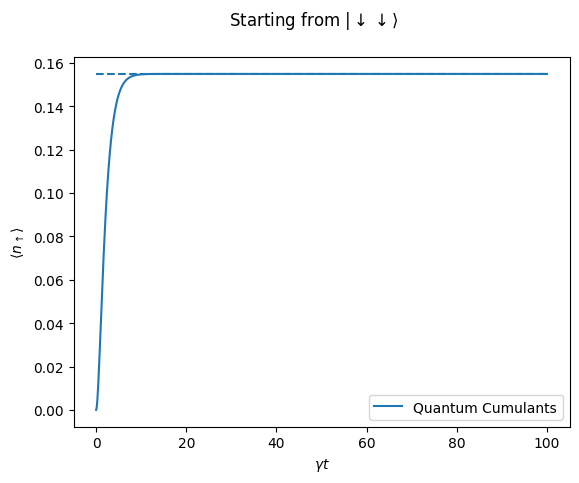

In [21]:
figure()
plot(T, popup_QC, label="Quantum Cumulants")
hlines(stationnary_state, T[1], T[end], linestyle="--")
xlabel(L"$\gamma t$")
ylabel(L"$\langle  n_{\uparrow} \rangle $")
suptitle(L"Starting from $|\downarrow \downarrow \rangle $")
legend()
pygui(false); gcf()
# pygui(true); show()

### Benchmark

In [22]:
@benchmark sol = solve(prob_ss, SSRootfind())

BenchmarkTools.Trial: 3571 samples with 1 evaluation per sample.
 Range (min … max):  1.308 ms …  15.048 ms  ┊ GC (min … max): 0.00% … 90.23%
 Time  (median):     1.347 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.390 ms ± 315.165 μs  ┊ GC (mean ± σ):  1.37% ±  5.16%

  ▂▁ ▄█▇▃▃▂▂▃▃▃▂▂▁                                            ▁
  ██▆███████████████▇███▇▇█▆▆▇▆▇▆▆▅▆▄▅▄▅▅▅▄▆▅▁▅▄▄▃▄▁▃▄▁▁▃▅▃▃▅ █
  1.31 ms      Histogram: log(frequency) by time      1.76 ms <

 Memory estimate: 177.76 KiB, allocs estimate: 1103.

In [23]:
@benchmark OrdinaryDiffEq.solve(prob, OrdinaryDiffEq.DP5(), saveat=T;
            reltol=1.0e-15,
            abstol=1.0e-15).u

BenchmarkTools.Trial: 537 samples with 1 evaluation per sample.
 Range (min … max):  9.033 ms …  19.592 ms  ┊ GC (min … max): 0.00% … 51.47%
 Time  (median):     9.229 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   9.316 ms ± 664.202 μs  ┊ GC (mean ± σ):  0.40% ±  3.16%

  ▆█     ▃▇▄ ▁  ▁                                              
  ███▅▆▇▆█████▆███▆▆▅▅▆▅▅▃▄▃▃▃▃▃▃▁▃▃▂▁▂▃▃▃▃▁▁▁▁▁▁▁▃▂▁▁▂▃▁▁▁▁▂ ▃
  9.03 ms         Histogram: frequency by time        10.2 ms <

 Memory estimate: 439.24 KiB, allocs estimate: 2076.

# Brouillons

In [24]:
# prob = SteadyStateProblem(fsolve, u0, p0)
# using NonlinearSolve

# ft(u, p) = u .* u .- p
# u0 = [1.0, 1.0]
# p = 2.0
# prob = NonlinearProblem(f, u0, p)
# sol = solve(prob, NewtonRaphson())
# Integration parameter
# tstep = 0.1
# T = [0:tstep:10;]; # Normalised time
# f(du, u, params) = ccall(("diffeqf", "liballfuncs.dll"), Cvoid, (Ptr{ComplexF64}, Ptr{ComplexF64}, Ptr{ComplexF64}), du, u, params)
# fsolve(du, u, p, t) = f(du, u, p0)
# prob = OrdinaryDiffEq.ODEProblem(fsolve, u0, (T[1], T[end]))
# sol = OrdinaryDiffEq.solve(prob, OrdinaryDiffEq.DP5(), saveat=T;
#             reltol=1.0e-15,
#             abstol=1.0e-15).u;
# popup_QC = [sum(real(sol[i][1:N])) for i=1:length(T)]